## Import Libs

In [1]:
import os
import random
import gc
import time
import copy
import sys
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn.functional as F
from torch import nn
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler, CosineAnnealingLR
import timm

from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
from collections import defaultdict
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold
from sklearn.metrics import roc_curve, auc, roc_auc_score

import warnings # 避免一些可以忽略的报错
warnings.filterwarnings('ignore')
# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
sr_ = Style.RESET_ALL

/data1/hjs/anaconda3/envs/transformers/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## CONFIG

In [2]:
is_debug = False
use_803098 = False
use_401059_val = True
use_1954_train = True # 2024_0 + 2024_1 + 2020_1
use_1977_train = False # 2024_0 + 2024_1 + 2020_1
use_10999_train = False # 2024_0 + 2024_1 + 2020_1 + 2019_1
use_401059_train = False # 2024_0 + 2024_1

class CONFIG:
    seed = 308
    epochs = 32 if not is_debug else 2
    
    train_batch_size = 32
    valid_batch_size = 512
    img_size = [160, 160]
    now_cv = 0
    n_classes = 2
    n_folds = 5
    
    n_accumulate = 1.0
    n_workers = os.cpu_count()
    
    formatted_time = None
    ckpt_save_path = None

    learning_rate = 1e-3 * train_batch_size * n_accumulate / 32
    # learning_rate = 1e-5 * train_batch_size / 32 # eva02
    total_sample = 1954
    T_max = [1586 * epochs / train_batch_size // n_accumulate,
             1522 * epochs / train_batch_size // n_accumulate,
             1582 * epochs / train_batch_size // n_accumulate,
             1574 * epochs / train_batch_size // n_accumulate,
             1552 * epochs / train_batch_size // n_accumulate] # 401059
    min_lr = 1e-6
    weight_decay = 1e-6
    scheduler = "CosineAnnealingWithWarmupLR" # 'CosineAnnealingLR'
    DataParallel = True

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    """
    tf_efficientnet_b0_ns
    convnext_atto_ols.a2_in1k
    tiny_vit_21m_512.dist_in22k_ft_in1k
    eva02_base_patch14_224.mim_in22k
    tf_efficientnetv2_s.in21k_ft_in1k
    tf_efficientnetv2_l.in21k_ft_in1k
    convnextv2_tiny.fcmae_ft_in22k_in1k_384
    convnext_tiny.fb_in22k_ft_in1k_384

    efficientvit_b0.r224_in1k
    efficientvit_b3.r256_in1k

    edgenext_base.in21k_ft_in1k
    eca_nfnet_l0.ra2_in1k
    """
    model_name = "tf_efficientnetv2_s.in21k_ft_in1k"
    is_pretrained = False
    backbone_grad = True
    use_gempool = False
    ckpt_paths = "/data1/hjs/pythonProject/pythonProject/ISIC2024/ckpt"
    smooth_threshold = 0.05

    old_my_train_csv = "/data1/hjs/pythonProject/pythonProject/ISIC2024/my_train_with_sgkfold.csv"
    my_train_csv = "/data1/hjs/pythonProject/pythonProject/ISIC2024/my_train_with_sgkfold.csv"
    train_img_dir = "/data1/hjs/pythonProject/pythonProject/ISIC2024/image"
    new_train_img_dir = "/data1/hjs/pythonProject/pythonProject/ISIC2024/new_1_imgs"
    train_1954_csv = "/data1/hjs/pythonProject/pythonProject/ISIC2024/train_1954.csv"
    train_1977_csv = "/data1/hjs/pythonProject/pythonProject/ISIC2024/train_1977.csv"
    train_793_csv = "/data1/hjs/pythonProject/pythonProject/ISIC2024/train_793.csv"
    train_10999_csv = "/data1/hjs/pythonProject/pythonProject/ISIC2024/train_10999.csv"

if CONFIG.DataParallel:
    os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
    print("IN DataParallel!")
else:
    os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
    print("NO IN DataParallel!")

IN DataParallel!


## Set Random Seed

In [3]:
def set_seed(seed=308):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
set_seed(CONFIG.seed)

## Data Progress

In [4]:
# root_dir = "/kaggle/input/isic-2024-challenge/train-image/image"
# img_ids = os.listdir(root_dir)

# min_size = 9999
# max_size = 0
# n_0_64 = 0
# n_64_96 = 0
# n_96_160 = 0
# n_160_224 = 0
# n_224_269 = 0
# for img_id in tqdm(img_ids):
#     path = os.path.join(root_dir, img_id)
#     a = Image.open(path)
#     s = np.array(a).shape[0]
#     if s > max_size:
#         max_size = s
#     if s < min_size:
#         min_size = s
        
#     if s >= 0 and s < 64:
#         n_0_64 += 1
#     elif s >= 64 and s < 96:
#         n_64_96 += 1
#     elif s >= 96 and s < 160:
#         n_96_160 += 1
#     elif s >= 160 and s < 224:
#         n_160_224 += 1
#     elif s >= 224:
#         n_224_269 += 1
        
# print(f"max_size : {max_size}") # max_size : 269
# print(f"min_size : {min_size}") # min_size : 41

# print(f"n_0_64    : {n_0_64}")    # 86
# print(f"n_64_96   : {n_64_96}")   # 3461
# print(f"n_96_160  : {n_96_160}")  # 368914
# print(f"n_160_224 : {n_160_224}") # 28305
# print(f"n_224_269 : {n_224_269}") # 293

# """
# 以上代码运行时间 : 37:20
# """

In [5]:
if os.path.exists(CONFIG.my_train_csv):
    train = pd.read_csv(CONFIG.my_train_csv)
else:
    train = pd.read_csv(CONFIG.train_csv)

valid = pd.read_csv(CONFIG.old_my_train_csv)
train

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence,kfold
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282,4
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455,0
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040,0
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998,2
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401054,ISIC_9999937,0,IP_1140263,70.0,male,anterior torso,6.80,TBP tile: close-up,3D: XP,22.574335,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999988,4
401055,ISIC_9999951,0,IP_5678181,60.0,male,posterior torso,3.11,TBP tile: close-up,3D: white,19.977640,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999820,1
401056,ISIC_9999960,0,IP_0076153,65.0,female,anterior torso,2.05,TBP tile: close-up,3D: XP,17.332567,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999416,2
401057,ISIC_9999964,0,IP_5231513,30.0,female,anterior torso,2.80,TBP tile: close-up,3D: XP,22.288570,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,0


In [6]:
if not os.path.exists(CONFIG.my_train_csv):
    print("贴 KFold....")
    # # 设置StratifiedKFold参数
    # skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=308)

    # # 创建一个新的列来保存KFold标签
    # train['kfold'] = -1

    # # 遍历每个fold并分配标签
    # for fold, (train_idx, val_idx) in enumerate(skf.split(train, train['target'])):
    #     train.loc[val_idx, 'kfold'] = fold
train

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence,kfold
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282,4
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455,0
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040,0
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998,2
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401054,ISIC_9999937,0,IP_1140263,70.0,male,anterior torso,6.80,TBP tile: close-up,3D: XP,22.574335,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999988,4
401055,ISIC_9999951,0,IP_5678181,60.0,male,posterior torso,3.11,TBP tile: close-up,3D: white,19.977640,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999820,1
401056,ISIC_9999960,0,IP_0076153,65.0,female,anterior torso,2.05,TBP tile: close-up,3D: XP,17.332567,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999416,2
401057,ISIC_9999964,0,IP_5231513,30.0,female,anterior torso,2.80,TBP tile: close-up,3D: XP,22.288570,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,0


In [7]:
if use_803098:
    new_train = train
else:
    if use_1954_train:
        new_train = pd.read_csv(CONFIG.train_1954_csv)
    elif use_1977_train:
        new_train = pd.read_csv(CONFIG.train_1977_csv)
    elif use_10999_train:
        new_train = pd.read_csv(CONFIG.train_10999_csv)
    elif use_401059_train:
        new_train = pd.read_csv(CONFIG.my_train_csv)
    else:
        new_train = pd.read_csv(CONFIG.train_793_csv)
    # train_0 = train[train["target"] != 1] # 400666 rows × 56 columns
    # train_1 = train[train["target"] == 1] # 393 rows × 56 columns

    # train_0 = train_0.reset_index(drop=True)
    # train_1 = train_1.reset_index(drop=True)

    # # train_1[train_1["kfold"] == 4] # [78, 79, 79, 79, 78] sum --> 393

    # # 0 : 1 ---> 1020 : 1

    # # 每个 fold 取 80 个样本 总共 400
    # some_train_0 = []
    # for fold in range(CONFIG.n_folds):
    #     _tmp = train_0[train_0["kfold"] == fold].reset_index(drop=True).iloc[:200, :]
    #     some_train_0.append(_tmp)

    # some_train_0 = pd.concat(some_train_0).reset_index(drop=True)
    # some_train_0

    # new_train = pd.concat([some_train_0, train_1]).reset_index(drop=True)
    # new_train = pd.concat([new_train, train_1_2020]).reset_index(drop=True)
    # new_train = new_train.sample(frac=1).reset_index(drop=True)
new_train

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence,kfold
0,ISIC_6249729,1,IP_0973797,65.0,male,anterior torso,1.74,TBP tile: close-up,3D: XP,23.844375,...,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Superficial",NaN,NaN,NaN,99.999332,0
1,ISIC_0091081,0,IP_4414342,40.0,female,posterior torso,2.63,TBP tile: close-up,3D: XP,24.385464,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999452,2
2,ISIC_9963177,1,IP_1165806,70.0,male,torso,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
3,ISIC_0092262,0,IP_8078890,80.0,male,head/neck,4.04,TBP tile: close-up,3D: white,17.336060,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,81.093390,1
4,ISIC_6025411,1,IP_3631110,45.0,male,head/neck,3.66,TBP tile: close-up,3D: XP,22.511600,...,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Nodular",NaN,NaN,NaN,98.159915,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1949,ISIC_0429895,1,IP_1045174,65.0,male,head/neck,3.15,TBP tile: close-up,3D: white,11.582197,...,Malignant::Malignant epidermal proliferations:...,Malignant,Malignant epidermal proliferations,"Squamous cell carcinoma, Invasive",NaN,NaN,NaN,NaN,0.000002,3
1950,ISIC_0084802,0,IP_3921915,50.0,male,anterior torso,8.20,TBP tile: close-up,3D: XP,24.091715,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,98.759043,0
1951,ISIC_4495069,1,IP_9324599,85.0,male,posterior torso,8.54,TBP tile: close-up,3D: white,16.806420,...,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Nodular",NaN,NaN,NaN,50.681180,4
1952,ISIC_2439617,1,IP_8977835,80.0,male,anterior torso,7.40,TBP tile: close-up,3D: white,21.430380,...,Malignant::Malignant melanocytic proliferation...,Malignant,Malignant melanocytic proliferations (Melanoma),Melanoma in situ,"Melanoma in situ, Lentigo maligna type",NaN,NaN,NaN,99.999960,4


## Dataset and DataLoader

In [8]:
# class HairAugmentation(A.ImageOnlyTransform):
#     def __init__(self, num_hairs=5, hair_color=(0, 0, 0), always_apply=False, p=0.5):
#         super(HairAugmentation, self).__init__(always_apply, p)
#         self.num_hairs = num_hairs
#         self.hair_color = hair_color

#     def apply(self, img, **params):
#         img = img.copy()
#         h, w, _ = img.shape
        
#         for _ in range(self.num_hairs):
#             # Randomly choose the position and size of the hair
#             x1, y1 = random.randint(0, w), random.randint(0, h)
#             x2, y2 = random.randint(0, w), random.randint(0, h)
#             thickness = random.randint(1, 1)  # Making the hair thinner
#             img = cv2.line(img, (x1, y1), (x2, y2), self.hair_color, thickness)
        
#         return img

#     def get_params_dependent_on_targets(self, params):
#         return {}

#     def get_transform_init_args_names(self):
#         return ("num_hairs", "hair_color")
    
# # HairAugmentation(num_hairs=10, hair_color=(0, 0, 0), p=1.0),

class HairAugmentation(A.ImageOnlyTransform):
    def __init__(self, num_hairs_range=(5, 15), hair_color_range=((0, 0, 0), (255, 255, 255)), always_apply=False, p=0.5):
        super(HairAugmentation, self).__init__(always_apply, p)
        self.num_hairs_range = num_hairs_range
        self.hair_color_range = hair_color_range

    def apply(self, img, **params):
        img = img.copy()
        h, w, _ = img.shape

        num_hairs = random.randint(self.num_hairs_range[0], self.num_hairs_range[1])
        hair_color = (
            random.randint(self.hair_color_range[0][0], self.hair_color_range[1][0]),
            random.randint(self.hair_color_range[0][1], self.hair_color_range[1][1]),
            random.randint(self.hair_color_range[0][2], self.hair_color_range[1][2])
        )

        for _ in range(num_hairs):
            # Randomly choose the position and size of the hair
            x1, y1 = random.randint(0, w), random.randint(0, h)
            x2, y2 = random.randint(0, w), random.randint(0, h)
            thickness = random.randint(1, 1)  # Making the hair thinner
            img = cv2.line(img, (x1, y1), (x2, y2), hair_color, thickness)

        return img

    def get_params_dependent_on_targets(self, params):
        return {}

    def get_transform_init_args_names(self):
        return ("num_hairs_range", "hair_color_range")
    
# HairAugmentation(num_hairs_range=(5, 15), hair_color_range=((0, 0, 0), (255, 255, 255)), p=1.0)

In [9]:
def transform(img):
    composition = A.Compose([
        A.Resize(CONFIG.img_size[0], CONFIG.img_size[1]),
        ToTensorV2(),
    ])
    return composition(image=img)["image"]

# def transform_train(img):
#     composition = A.Compose([
#         A.Resize(CONFIG.img_size[0], CONFIG.img_size[1]),
#         HairAugmentation(num_hairs_range=(5, 15), hair_color_range=((0, 0, 0), (255, 255, 255)), p=0.5),
#         ToTensorV2(),
#     ])
#     return composition(image=img)["image"]


# def transform_val(img):
#     composition = A.Compose([
#         A.Resize(CONFIG.img_size[0], CONFIG.img_size[1]),
#         ToTensorV2(),
#     ])
#     return composition(image=img)["image"]

def transform_train(img):
    composition = A.Compose([
        HairAugmentation(num_hairs_range=(5, 15), hair_color_range=((0, 0, 0), (255, 255, 255)), p=0.5),
        A.Transpose(p=0.5),
        A.VerticalFlip(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightness(limit=0.2, p=0.75),
        A.RandomContrast(limit=0.2, p=0.75),
        A.OneOf([
            A.MotionBlur(blur_limit=5),
            A.MedianBlur(blur_limit=5),
            A.GaussianBlur(blur_limit=5),
            A.GaussNoise(var_limit=(5.0, 30.0)),
        ], p=0.7),

        A.OneOf([
            A.OpticalDistortion(distort_limit=1.0),
            A.GridDistortion(num_steps=5, distort_limit=1.),
            A.ElasticTransform(alpha=3),
        ], p=0.7),

        A.CLAHE(clip_limit=4.0, p=0.7),
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.85),
        A.Resize(CONFIG.img_size[0], CONFIG.img_size[1]),
        A.Cutout(max_h_size=int(CONFIG.img_size[0] * 0.375), max_w_size=int(CONFIG.img_size[1] * 0.375), num_holes=1, p=0.7),    
        A.Normalize(),
        ToTensorV2(),
    ])
    return composition(image=img)["image"]


def transform_val(img):
    composition = A.Compose([
        A.Resize(CONFIG.img_size[0], CONFIG.img_size[1]),
        A.Normalize(),
        ToTensorV2(),
    ])
    return composition(image=img)["image"]

# transform_train = A.Compose([
#     A.Transpose(p=0.5),
#     A.VerticalFlip(p=0.5),
#     A.HorizontalFlip(p=0.5),
#     A.RandomBrightness(limit=0.2, p=0.75),
#     A.RandomContrast(limit=0.2, p=0.75),
#     A.OneOf([
#         A.MotionBlur(blur_limit=5),
#         A.MedianBlur(blur_limit=5),
#         A.GaussianBlur(blur_limit=5),
#         A.GaussNoise(var_limit=(5.0, 30.0)),
#     ], p=0.7),

#     A.OneOf([
#         A.OpticalDistortion(distort_limit=1.0),
#         A.GridDistortion(num_steps=5, distort_limit=1.),
#         A.ElasticTransform(alpha=3),
#     ], p=0.7),

#     A.CLAHE(clip_limit=4.0, p=0.7),
#     A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
#     A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.85),
#     A.Resize(CONFIG.img_size[0], CONFIG.img_size[1]),
#     A.Cutout(max_h_size=int(CONFIG.img_size[0] * 0.375), max_w_size=int(CONFIG.img_size[1] * 0.375), num_holes=1, p=0.7),    
#     A.Normalize(),
#     ToTensorV2(),
# ])

# transform_val = A.Compose([
#     A.Resize(CONFIG.img_size[0], CONFIG.img_size[1]),
#     A.Normalize(),
#     ToTensorV2(),
# ])

In [10]:
class MyDataset(Dataset):
    def __init__(self, df, transform=None, mode="train", threshold=CONFIG.smooth_threshold):
        super().__init__()
        self.df = df
        self.transform = transform
        self.mode = mode
        self.threshold = threshold

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx, :]
        img_id = row.isic_id + ".jpg"
        label = row.target
        
        if use_803098:
            if label.item() == 1:
                img_path = os.path.join(CONFIG.new_train_img_dir, img_id)
            else:
                img_path = os.path.join(CONFIG.train_img_dir, img_id)
        else:
            img_path = os.path.join(CONFIG.train_img_dir, img_id)
        img = Image.open(img_path)
        img = np.array(img)

        if self.transform != None:
            img = self.transform(img)
        
        if self.mode == "train":
            if label == 0:
                label = torch.tensor([1 - self.threshold, 0 + self.threshold], dtype=torch.float32)
            elif label == 1:
                label = torch.tensor([0 + self.threshold, 1 - self.threshold], dtype=torch.float32)
            else:
                raise("label is not 0 or 1")
        elif self.mode == "valid":
            if label == 0:
                label = torch.tensor([1, 0], dtype=torch.float32)
            elif label == 1:
                label = torch.tensor([0, 1], dtype=torch.float32)
            else:
                raise("label is not 0 or 1")
        else:
            raise("mode is not train or valid")

        return img, label

In [11]:
def prepare_loaders(df, fold=0):
    df_train = df[df["kfold"] != fold]
    if use_401059_val:
        df_valid = valid[valid["kfold"] == fold]
    else:
        df_valid = df[df["kfold"] == fold]
    
    train_datasets = MyDataset(df=df_train, transform=transform_train, mode="train")
    valid_datasets = MyDataset(df=df_valid, transform=transform_val, mode="valid")
    
    train_loader = DataLoader(train_datasets, batch_size=CONFIG.train_batch_size, num_workers=CONFIG.n_workers, shuffle=True, pin_memory=True)
    valid_loader = DataLoader(valid_datasets, batch_size=CONFIG.valid_batch_size, num_workers=CONFIG.n_workers, shuffle=False, pin_memory=True)
    
    
    return train_loader, valid_loader

In [12]:
# train_loader, valid_loader = prepare_loaders(train)
# x, y = next(iter(train_loader))
# x.shape
# x, y = next(iter(valid_loader))
# y

## Evaluation

In [13]:
def compute_pAUC(y_true, y_scores, min_tpr=0.8):
    y_hat = y_scores
    if len(np.unique(y_true)) == 1:
        return 0.0  # 或者其他你认为合适的默认值
    min_tpr = min_tpr
    max_fpr = abs(1 - min_tpr)
    
    v_gt = abs(y_true - 1)
    v_pred = np.array([1.0 - x for x in y_hat])
    
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    
    return partial_auc

# def compute_pAUC(y_true, y_scores, min_tpr=0.8):
#     """
#     计算pAUC, 特别是高于min_tpr (例如0.8) 部分的面积。

#     参数:
#     y_true (array-like): 真实标签 (0或1) 。
#     y_scores (array-like): 预测概率或得分。
#     min_tpr (float): 最小TPR阈值, 默认值为0.8。

#     返回:
#     pAUC (float): ROC曲线在min_tpr以上部分的面积。
#     """
#     # 计算fpr, tpr, 和阈值
#     fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    
#     # 找到高于min_tpr的部分
#     idx = np.where(tpr >= min_tpr)[0]
    
#     if len(idx) == 0:
#         return 0.0
    
#     # 截取高于min_tpr的部分
#     fpr = fpr[idx]
#     tpr = tpr[idx]
#     # 确保有足够的点进行AUC计算
#     if len(fpr) < 2 or len(tpr) < 2:
#         return 0.0
    
#     # 计算高于min_tpr部分的AUC
#     pAUC = auc(fpr, tpr)
#     # 归一化pAUC使其在[0, 0.2]范围内
#     max_possible_auc = (1 - min_tpr)
#     pAUC_normalized = pAUC * max_possible_auc
    
#     return pAUC_normalized

"""
# 假设y_true是实际标签, y_scores是模型预测的得分
y_true = [0, 0, 1, 1]
y_scores = [0.1, 0.4, 0.35, 0.8]

pAUC = compute_pAUC(y_true, y_scores)
print(f"pAUC: {pAUC:.4f}")
"""
y_true = np.array([0.0, 0.0, 1.0, 1.0])
y_scores = np.array([0.0, 0.0, 0.9, 0.1])

pAUC = compute_pAUC(y_true, y_scores)
print(f"pAUC: {pAUC:.4f}")

pAUC: 0.2000


## DL Model

In [14]:
def updata_req_grad(models, requires_grad=True):
    for model in models:
        for param in model.parameters():
            param.requires_grad = requires_grad

In [15]:
class GeMPool(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeMPool, self).__init__()
        self.p = nn.Parameter(torch.ones(1) * p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
    
    def gem(self, x, p=3, eps=1e-6):
        return torch.mean(x.clamp(min=eps).pow(p), dim=(-2, -1)).pow(1./p)
    
    def __repr__(self):
        return self.__class__.__name__ + f'(p={self.p.data.tolist()[0]:.4f}, eps={self.eps})'

In [16]:
class ISIC2024Model(nn.Module):
    def __init__(self):
        super(ISIC2024Model, self).__init__()
        self.backbone = timm.create_model(model_name=CONFIG.model_name, 
                                          pretrained=CONFIG.is_pretrained)
        self.backbone.load_state_dict(torch.load(os.path.join(CONFIG.ckpt_paths, CONFIG.model_name + ".bin")))

        if "efficientnet" in CONFIG.model_name:
            in_features = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Identity()
            if CONFIG.use_gempool:
                self.backbone.global_pool = GeMPool()
        elif "convnext" in CONFIG.model_name or "tiny_vit" in CONFIG.model_name:
            in_features = self.backbone.head.fc.in_features
            self.backbone.head.fc = nn.Identity()
        elif "eva" in CONFIG.model_name:
            in_features = 768
        elif "efficientvit" in CONFIG.model_name:
            in_features = self.backbone.head.classifier[4].in_features
            self.backbone.head.classifier[4] = nn.Identity()
        elif "edgenext" in CONFIG.model_name:
            in_features = self.backbone.head.fc.in_features
            self.backbone.head.fc = nn.Identity()
        elif "nfnet" in CONFIG.model_name:
            in_features = self.backbone.head.fc.in_features
            self.backbone.head.fc = nn.Identity()

        self.head = nn.Sequential(
            nn.Linear(in_features, CONFIG.n_classes)
        )
        
        
    def forward(self, x):
        _tmp = self.backbone(x)
        output = self.head(_tmp)
        return output

In [17]:
model = ISIC2024Model()
model

ISIC2024Model(
  (backbone): EfficientNet(
    (conv_stem): Conv2dSame(3, 24, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNormAct2d(
      24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): ConvBnAct(
          (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNormAct2d(
            24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (drop_path): Identity()
        )
        (1): ConvBnAct(
          (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNormAct2d(
            24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
     

## Train and Valid Function

In [18]:
criterion = nn.CrossEntropyLoss()

"""
a = torch.tensor([0, 0, 1, 1]).float()
b = torch.tensor([0.7, 0.2, 0.5, 0.3]).float()
c = torch.tensor([[0.7], [0.2], [0.5], [0.3]]).float()
criterion(a, b)
"""

'\na = torch.tensor([0, 0, 1, 1]).float()\nb = torch.tensor([0.7, 0.2, 0.5, 0.3]).float()\nc = torch.tensor([[0.7], [0.2], [0.5], [0.3]]).float()\ncriterion(a, b)\n'

In [19]:
def train_one_epoch(model, optimizer, scheduler, train_loader, epoch):
    model.train()
    
    y_preds = []
    y_trues = []
    
    dataset_size = 0
    running_loss = 0.0
    bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for step, (images, labels) in bar:
        optimizer.zero_grad()
        
        batch_size = images.size(0)
        if CONFIG.DataParallel:
            images = images.cuda().float()
            labels = labels.cuda().float()
        else:
            images = images.to(CONFIG.device, dtype=torch.float)
            labels = labels.to(CONFIG.device, dtype=torch.float)
            
        outputs = model(images)
        outputs = F.softmax(outputs)
        loss = criterion(outputs, labels) / CONFIG.n_accumulate
        loss.backward()
        
        if (step + 1) % CONFIG.n_accumulate == 0:
            optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
        y_preds.append(outputs[:, 1].flatten().detach().cpu().numpy())
        y_trues.append(labels.argmax(1).detach().cpu().numpy())

        train_cv = compute_pAUC(np.concatenate(y_trues).round(), np.concatenate(y_preds))

        running_loss += (loss.item() * batch_size)

        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch,
                        Train_Loss=epoch_loss,
                        Train_CV_pAUC=train_cv,
                        LR=optimizer.param_groups[0]['lr'])
    # 确保在最后一个累积周期后，进行一次参数更新
    if (step + 1) % CONFIG.n_accumulate != 0:
        optimizer.step()
        optimizer.zero_grad()
        if scheduler is not None:
                scheduler.step()
        
    return epoch_loss, train_cv

In [20]:
@torch.inference_mode()
def valid_one_epoch(model, optimizer, valid_loader, epoch):
    model.eval()
    
    y_preds = []
    y_trues = []
    dataset_size = 0
    running_loss = 0.0
    bar = tqdm(enumerate(valid_loader), total=len(valid_loader))
    with torch.no_grad():
        for step, (images, labels) in bar:
            batch_size = images.size(0)
            if CONFIG.DataParallel:
                images = images.cuda().float()
                labels = labels.cuda().float()
            else:
                images = images.to(CONFIG.device, dtype=torch.float)
                labels = labels.to(CONFIG.device, dtype=torch.float)

            outputs = model(images)
            outputs = F.softmax(outputs)
            loss = criterion(outputs, labels) / CONFIG.n_accumulate

            y_preds.append(outputs[:, 1].flatten().detach().cpu().numpy())
            y_trues.append(labels.argmax(1).detach().cpu().numpy())
            valid_cv = compute_pAUC(np.concatenate(y_trues), np.concatenate(y_preds))
        
            running_loss += (loss.item() * batch_size)

            dataset_size += batch_size

            epoch_loss = running_loss / dataset_size

            bar.set_postfix(Epoch=epoch,
                            Valid_Loss=epoch_loss,
                            Valid_CV_pAUC=valid_cv,
                            LR=optimizer.param_groups[0]['lr'])
        

        y_preds = np.concatenate(y_preds)
        y_trues = np.concatenate(y_trues)
        cv = compute_pAUC(y_trues, y_preds) 
    
    return epoch_loss, cv

In [21]:
# 获取当前时间的时间戳
current_time = time.time()
print("当前时间戳:", current_time)

# 将时间戳转换为本地时间结构
local_time = time.localtime(current_time)

# 格式化本地时间
CONFIG.formatted_time = time.strftime('%Y-%m-%d_%H:%M:%S', local_time)
print("当前时间:", CONFIG.formatted_time)

CONFIG.ckpt_save_path = f"output/{CONFIG.formatted_time}_{CONFIG.model_name}_output"
if os.path.exists(CONFIG.ckpt_save_path) is False:
    os.makedirs(CONFIG.ckpt_save_path)

当前时间戳: 1724782369.2794921
当前时间: 2024-08-28_02:12:49


In [22]:
def run_training(fold, model, optimizer, scheduler, train_loader, valid_loader, num_epochs=CONFIG.epochs, now_cv=CONFIG.now_cv):
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {} x {}\n".format(torch.cuda.get_device_name(), torch.cuda.device_count()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_cv = now_cv
    best_model_path = None
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1):
        gc.collect()
        train_epoch_loss, train_epoch_cv = train_one_epoch(model, optimizer, scheduler, train_loader, epoch)
        valid_epoch_loss, valid_epoch_cv = valid_one_epoch(model, optimizer, valid_loader, epoch)
        print(f"epoch: {epoch}, LOSS = {valid_epoch_loss}, CV = {valid_epoch_cv}")
        
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(valid_epoch_loss)
        history['Train CV'].append(train_epoch_cv)
        history['Valid CV'].append(valid_epoch_cv)
        history['lr'].append(scheduler.get_lr()[0])
        
        # deep copy the model
        if valid_epoch_cv >= best_epoch_cv:
            print(f"{b_}epoch: {epoch}, Validation CV Improved ({best_epoch_cv} ---> {valid_epoch_cv}))")
            best_epoch_cv = valid_epoch_cv
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = "./{}/{}_CV_{:.4f}_Loss{:.4f}_epoch{:.0f}.bin".format(CONFIG.ckpt_save_path, fold, best_epoch_cv, valid_epoch_loss, epoch)
            best_model_path = PATH
            torch.save(model.state_dict(), PATH)
            print(f"Model Saved{sr_}")
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best CV: {:.4f}".format(best_epoch_cv))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, history, best_model_path

## Optimizer

In [23]:
class CosineAnnealingWithWarmupLR(_LRScheduler):
    def __init__(self, optimizer, T_max, eta_min=0, warmup_epochs=10, last_epoch=-1):
        self.T_max = T_max
        self.eta_min = eta_min
        self.warmup_epochs = warmup_epochs
        self.cosine_epochs = T_max - warmup_epochs
        super(CosineAnnealingWithWarmupLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        if self.last_epoch < self.warmup_epochs:
            # Linear warmup
            return [(base_lr * (self.last_epoch + 1) / self.warmup_epochs) for base_lr in self.base_lrs]
        else:
            # Cosine annealing
            cosine_epoch = self.last_epoch - self.warmup_epochs
            return [self.eta_min + (base_lr - self.eta_min) * (1 + math.cos(math.pi * cosine_epoch / self.cosine_epochs)) / 2 for base_lr in self.base_lrs]


In [24]:
# 学习率随训练下降
def fetch_scheduler(optimizer, T_max, min_lr):
    if CONFIG.scheduler == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=T_max, 
                                                   eta_min=min_lr)
    elif CONFIG.scheduler == "CosineAnnealingWithWarmupLR":
        scheduler = CosineAnnealingWithWarmupLR(optimizer, T_max=T_max, eta_min=min_lr, warmup_epochs=T_max//CONFIG.train_batch_size)
        
    elif CONFIG.scheduler == None:
        return None
        
    return scheduler

In [25]:
# optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG.learning_rate, 
#                               weight_decay=CONFIG.weight_decay)
# scheduler = fetch_scheduler(optimizer, T_max=CONFIG.T_max, min_lr=CONFIG.min_lr)

## Start Training

In [26]:
# 打开文件，并以写入模式 'w' 打开，写入cfg信息
with open(f'{CONFIG.ckpt_save_path}/info.txt', 'w') as file:
    # 写入字符串到文件
    if use_1977_train:
        file.write(f'train on 1977\n')
    elif use_10999_train:
        file.write(f'train on 10999\n')
    elif use_401059_train:
        file.write(f'train on 401059\n')
    else:
        file.write(f'train on 793\n')

    if use_401059_val:
        file.write(f'valid on 401059\n')
        
    file.write(f'seed: {CONFIG.seed}\n')
    file.write(f'epochs: {CONFIG.epochs}\n')
    file.write(f'train_batch_size: {CONFIG.train_batch_size}\n')
    file.write(f'valid_batch_size: {CONFIG.valid_batch_size}\n')
    file.write(f'img_size: {CONFIG.img_size}\n')
    file.write(f'n_classes: {CONFIG.n_classes}\n')
    file.write(f'n_folds: {CONFIG.n_folds}\n')
    file.write(f'learning_rate: {CONFIG.learning_rate}\n')
    file.write(f'model_name: {CONFIG.model_name}\n')
    file.write(f'use_gempool: {CONFIG.use_gempool}\n')
    file.write(f'smooth_threshold: {CONFIG.smooth_threshold}\n')

In [27]:
oof = []
true = []
historys = []

for fold in range(0, CONFIG.n_folds):
    print(f"==================== Train on Fold {fold+1} ====================")
    del model
    torch.cuda.empty_cache()
    model = ISIC2024Model()
    if CONFIG.DataParallel:
        device_ids = [0, 1] # id为0和1的两块显卡
        model = torch.nn.DataParallel(model, device_ids=device_ids)
        model = model.cuda()
    else:
        model = model.to(CONFIG.device)
        
    optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG.learning_rate, 
                                  weight_decay=CONFIG.weight_decay)
    scheduler = fetch_scheduler(optimizer, T_max=CONFIG.T_max[fold], min_lr=CONFIG.min_lr)
    
    train_loader, valid_loader = prepare_loaders(new_train, fold) # 修改
    model, history, best_model_path = run_training(fold+1, model, optimizer, scheduler, 
                                                   train_loader, valid_loader, 
                                                   num_epochs=CONFIG.epochs, now_cv=CONFIG.now_cv)
    historys.append(history)
    
    bar = tqdm(enumerate(valid_loader), total=len(valid_loader))
    with torch.no_grad():
        for step, (images, labels) in bar:
            batch_size = images.size(0)
            if CONFIG.DataParallel:
                images = images.cuda().float()
                labels = labels.cuda().float()
            else:
                images = images.to(CONFIG.device, dtype=torch.float)
                labels = labels.to(CONFIG.device, dtype=torch.float)

            outputs = model(images)
            outputs = F.softmax(outputs)
            
            oof.append(outputs[:, 1].flatten().detach().cpu().numpy())
            true.append(labels.argmax(1).detach().cpu().numpy())
        print() # 换行

oof = np.concatenate(oof)
true = np.concatenate(true)

==================== Train on Fold 1 ====================


[INFO] Using GPU: NVIDIA GeForce RTX 3080 Ti x 2



100%|██████████| 148/148 [00:36<00:00,  4.10it/s, Epoch=1, LR=0.001, Valid_CV_pAUC=0.0868, Valid_Loss=0.599]


epoch: 1, LOSS = 0.5993955178226043, CV = 0.08681760050564791
epoch: 1, Validation CV Improved (0 ---> 0.08681760050564791))
Model Saved



100%|██████████| 148/148 [00:33<00:00,  4.43it/s, Epoch=2, LR=0.000997, Valid_CV_pAUC=0.0885, Valid_Loss=0.594]


epoch: 2, LOSS = 0.5940608731640854, CV = 0.08850241674308978
epoch: 2, Validation CV Improved (0.08681760050564791 ---> 0.08850241674308978))
Model Saved



100%|██████████| 148/148 [00:33<00:00,  4.40it/s, Epoch=3, LR=0.000989, Valid_CV_pAUC=0.0868, Valid_Loss=0.469]

epoch: 3, LOSS = 0.4687813264331228, CV = 0.08684909274297757




100%|██████████| 148/148 [00:33<00:00,  4.38it/s, Epoch=4, LR=0.000976, Valid_CV_pAUC=0.0933, Valid_Loss=0.434]


epoch: 4, LOSS = 0.43432837650091816, CV = 0.09333870879611782
epoch: 4, Validation CV Improved (0.08850241674308978 ---> 0.09333870879611782))
Model Saved



100%|██████████| 148/148 [00:33<00:00,  4.42it/s, Epoch=5, LR=0.000958, Valid_CV_pAUC=0.0869, Valid_Loss=0.441]

epoch: 5, LOSS = 0.4413639198293143, CV = 0.08692614350418147




100%|██████████| 148/148 [00:34<00:00,  4.35it/s, Epoch=6, LR=0.000936, Valid_CV_pAUC=0.0726, Valid_Loss=0.332]

epoch: 6, LOSS = 0.33240502098072, CV = 0.07261234938735965




100%|██████████| 148/148 [00:33<00:00,  4.39it/s, Epoch=7, LR=0.000908, Valid_CV_pAUC=0.0989, Valid_Loss=0.35] 


epoch: 7, LOSS = 0.3495366030563529, CV = 0.09885132710429424
epoch: 7, Validation CV Improved (0.09333870879611782 ---> 0.09885132710429424))
Model Saved



100%|██████████| 148/148 [00:33<00:00,  4.37it/s, Epoch=8, LR=0.000877, Valid_CV_pAUC=0.111, Valid_Loss=0.471]


epoch: 8, LOSS = 0.47077255143855995, CV = 0.11111971332834178
epoch: 8, Validation CV Improved (0.09885132710429424 ---> 0.11111971332834178))
Model Saved



100%|██████████| 148/148 [00:33<00:00,  4.40it/s, Epoch=9, LR=0.000841, Valid_CV_pAUC=0.107, Valid_Loss=0.404]

epoch: 9, LOSS = 0.40382895959958864, CV = 0.10679327801332347




100%|██████████| 148/148 [00:33<00:00,  4.43it/s, Epoch=10, LR=0.000802, Valid_CV_pAUC=0.113, Valid_Loss=0.411]


epoch: 10, LOSS = 0.41126269580684394, CV = 0.11253376277964587
epoch: 10, Validation CV Improved (0.11111971332834178 ---> 0.11253376277964587))
Model Saved



100%|██████████| 148/148 [00:33<00:00,  4.38it/s, Epoch=11, LR=0.00076, Valid_CV_pAUC=0.113, Valid_Loss=0.388]


epoch: 11, LOSS = 0.38834627350650497, CV = 0.11295253938929424
epoch: 11, Validation CV Improved (0.11253376277964587 ---> 0.11295253938929424))
Model Saved



100%|██████████| 148/148 [00:33<00:00,  4.40it/s, Epoch=12, LR=0.000715, Valid_CV_pAUC=0.0986, Valid_Loss=0.426]

epoch: 12, LOSS = 0.42638118942899433, CV = 0.09864035126581809




100%|██████████| 148/148 [00:33<00:00,  4.41it/s, Epoch=13, LR=0.000668, Valid_CV_pAUC=0.114, Valid_Loss=0.442]


epoch: 13, LOSS = 0.44218530071183604, CV = 0.11365522608694366
epoch: 13, Validation CV Improved (0.11295253938929424 ---> 0.11365522608694366))
Model Saved



100%|██████████| 148/148 [00:33<00:00,  4.44it/s, Epoch=14, LR=0.000619, Valid_CV_pAUC=0.107, Valid_Loss=0.389]

epoch: 14, LOSS = 0.38928886457502676, CV = 0.10662880214309657




100%|██████████| 148/148 [00:33<00:00,  4.43it/s, Epoch=15, LR=0.000569, Valid_CV_pAUC=0.0986, Valid_Loss=0.389]

epoch: 15, LOSS = 0.38937422523436993, CV = 0.0985522062287436




100%|██████████| 148/148 [00:33<00:00,  4.40it/s, Epoch=16, LR=0.000518, Valid_CV_pAUC=0.0474, Valid_Loss=0.344]

epoch: 16, LOSS = 0.3436058886597814, CV = 0.04742819548372518




100%|██████████| 148/148 [00:33<00:00,  4.43it/s, Epoch=17, LR=0.000467, Valid_CV_pAUC=0.11, Valid_Loss=0.36] 

epoch: 17, LOSS = 0.36017778665557454, CV = 0.11042813936625652




100%|██████████| 148/148 [00:33<00:00,  4.41it/s, Epoch=18, LR=0.000417, Valid_CV_pAUC=0.115, Valid_Loss=0.357]


epoch: 18, LOSS = 0.35744614698309085, CV = 0.11540664489899594
epoch: 18, Validation CV Improved (0.11365522608694366 ---> 0.11540664489899594))
Model Saved



100%|██████████| 148/148 [00:33<00:00,  4.40it/s, Epoch=19, LR=0.000367, Valid_CV_pAUC=0.115, Valid_Loss=0.389]

epoch: 19, LOSS = 0.388645146083709, CV = 0.11480533883875234




100%|██████████| 148/148 [00:33<00:00,  4.38it/s, Epoch=20, LR=0.000318, Valid_CV_pAUC=0.105, Valid_Loss=0.397]

epoch: 20, LOSS = 0.3965813077067074, CV = 0.10526514765539736




100%|██████████| 148/148 [00:33<00:00,  4.42it/s, Epoch=21, LR=0.000272, Valid_CV_pAUC=0.108, Valid_Loss=0.389]

epoch: 21, LOSS = 0.38869746386339243, CV = 0.10799565015779343




100%|██████████| 148/148 [00:33<00:00,  4.39it/s, Epoch=22, LR=0.000228, Valid_CV_pAUC=0.115, Valid_Loss=0.395]

epoch: 22, LOSS = 0.3949913736742197, CV = 0.11464662239293746




100%|██████████| 148/148 [00:33<00:00,  4.44it/s, Epoch=23, LR=0.000187, Valid_CV_pAUC=0.112, Valid_Loss=0.385]

epoch: 23, LOSS = 0.3850424974680729, CV = 0.11235603284939398




100%|██████████| 148/148 [00:34<00:00,  4.35it/s, Epoch=24, LR=0.000149, Valid_CV_pAUC=0.113, Valid_Loss=0.39] 

epoch: 24, LOSS = 0.38972751105332365, CV = 0.11319447213398486




100%|██████████| 148/148 [00:33<00:00,  4.38it/s, Epoch=25, LR=0.000114, Valid_CV_pAUC=0.108, Valid_Loss=0.384]

epoch: 25, LOSS = 0.38363974204971807, CV = 0.10807198099094584




100%|██████████| 148/148 [00:33<00:00,  4.42it/s, Epoch=26, LR=8.39e-5, Valid_CV_pAUC=0.103, Valid_Loss=0.371]

epoch: 26, LOSS = 0.37080156112831264, CV = 0.10270737250627994




100%|██████████| 148/148 [00:33<00:00,  4.35it/s, Epoch=27, LR=5.8e-5, Valid_CV_pAUC=0.112, Valid_Loss=0.395]

epoch: 27, LOSS = 0.3946542011614497, CV = 0.11158432535726884




100%|██████████| 148/148 [00:33<00:00,  4.38it/s, Epoch=28, LR=3.67e-5, Valid_CV_pAUC=0.104, Valid_Loss=0.381]

epoch: 28, LOSS = 0.3806424290533394, CV = 0.10432272491659905




100%|██████████| 148/148 [00:33<00:00,  4.37it/s, Epoch=29, LR=2.02e-5, Valid_CV_pAUC=0.115, Valid_Loss=0.399]

epoch: 29, LOSS = 0.39868006846038945, CV = 0.1146990479228414




100%|██████████| 148/148 [00:34<00:00,  4.35it/s, Epoch=30, LR=8.7e-6, Valid_CV_pAUC=0.111, Valid_Loss=0.392]

epoch: 30, LOSS = 0.39189524675171894, CV = 0.11105307383434411




100%|██████████| 148/148 [00:33<00:00,  4.38it/s, Epoch=31, LR=2.35e-6, Valid_CV_pAUC=0.109, Valid_Loss=0.392]

epoch: 31, LOSS = 0.3915815001377835, CV = 0.10906869368870455




100%|██████████| 148/148 [00:33<00:00,  4.37it/s, Epoch=32, LR=1.2e-6, Valid_CV_pAUC=0.103, Valid_Loss=0.377] 

epoch: 32, LOSS = 0.37739230279350366, CV = 0.10284895835640791

Training complete in 0h 25m 46s
Best CV: 0.1154



100%|██████████| 148/148 [00:27<00:00,  5.34it/s]



==================== Train on Fold 2 ====================
[INFO] Using GPU: NVIDIA GeForce RTX 3080 Ti x 2



100%|██████████| 174/174 [00:40<00:00,  4.29it/s, Epoch=1, LR=0.001, Valid_CV_pAUC=0.0813, Valid_Loss=0.518]


epoch: 1, LOSS = 0.5177958024539115, CV = 0.08127890623096634
epoch: 1, Validation CV Improved (0 ---> 0.08127890623096634))
Model Saved



100%|██████████| 174/174 [00:40<00:00,  4.27it/s, Epoch=2, LR=0.000997, Valid_CV_pAUC=0.0841, Valid_Loss=0.342]


epoch: 2, LOSS = 0.3418749032258148, CV = 0.08411873232293027
epoch: 2, Validation CV Improved (0.08127890623096634 ---> 0.08411873232293027))
Model Saved



100%|██████████| 174/174 [00:40<00:00,  4.29it/s, Epoch=3, LR=0.000989, Valid_CV_pAUC=0.102, Valid_Loss=0.446] 


epoch: 3, LOSS = 0.44648314237067366, CV = 0.10201488140721099
epoch: 3, Validation CV Improved (0.08411873232293027 ---> 0.10201488140721099))
Model Saved



100%|██████████| 174/174 [00:40<00:00,  4.28it/s, Epoch=4, LR=0.000976, Valid_CV_pAUC=0.0686, Valid_Loss=0.331]

epoch: 4, LOSS = 0.3305832241371076, CV = 0.06864508098506542




100%|██████████| 174/174 [00:40<00:00,  4.26it/s, Epoch=5, LR=0.000958, Valid_CV_pAUC=0.0934, Valid_Loss=0.428]

epoch: 5, LOSS = 0.4284633236253549, CV = 0.09338516023149343




100%|██████████| 174/174 [00:40<00:00,  4.30it/s, Epoch=6, LR=0.000936, Valid_CV_pAUC=0.116, Valid_Loss=0.433]


epoch: 6, LOSS = 0.43297233990904593, CV = 0.11621351353147154
epoch: 6, Validation CV Improved (0.10201488140721099 ---> 0.11621351353147154))
Model Saved



100%|██████████| 174/174 [00:40<00:00,  4.25it/s, Epoch=7, LR=0.000908, Valid_CV_pAUC=0.046, Valid_Loss=0.423] 

epoch: 7, LOSS = 0.4230867268640176, CV = 0.045996261375893396




100%|██████████| 174/174 [00:40<00:00,  4.28it/s, Epoch=8, LR=0.000877, Valid_CV_pAUC=0.0966, Valid_Loss=0.562]

epoch: 8, LOSS = 0.5621521702870661, CV = 0.09657926968370087




100%|██████████| 174/174 [00:40<00:00,  4.29it/s, Epoch=9, LR=0.000841, Valid_CV_pAUC=0.11, Valid_Loss=0.441] 

epoch: 9, LOSS = 0.44115849904112786, CV = 0.10984722139166293




100%|██████████| 174/174 [00:40<00:00,  4.28it/s, Epoch=10, LR=0.000802, Valid_CV_pAUC=0.104, Valid_Loss=0.41]  

epoch: 10, LOSS = 0.41030480307742506, CV = 0.10411490067618594




100%|██████████| 174/174 [00:40<00:00,  4.32it/s, Epoch=11, LR=0.00076, Valid_CV_pAUC=0.0982, Valid_Loss=0.438]

epoch: 11, LOSS = 0.4382256805353382, CV = 0.09823190543584423




100%|██████████| 174/174 [00:40<00:00,  4.29it/s, Epoch=12, LR=0.000715, Valid_CV_pAUC=0.131, Valid_Loss=0.492]


epoch: 12, LOSS = 0.49154934241341514, CV = 0.13129737786902856
epoch: 12, Validation CV Improved (0.11621351353147154 ---> 0.13129737786902856))
Model Saved



100%|██████████| 174/174 [00:40<00:00,  4.28it/s, Epoch=13, LR=0.000668, Valid_CV_pAUC=0.114, Valid_Loss=0.479]

epoch: 13, LOSS = 0.4788837818120703, CV = 0.11368867980943645




100%|██████████| 174/174 [00:40<00:00,  4.28it/s, Epoch=14, LR=0.000619, Valid_CV_pAUC=0.112, Valid_Loss=0.441] 

epoch: 14, LOSS = 0.44148218414124757, CV = 0.11192958850771753




100%|██████████| 174/174 [00:40<00:00,  4.27it/s, Epoch=15, LR=0.000569, Valid_CV_pAUC=0.0888, Valid_Loss=0.409]

epoch: 15, LOSS = 0.4086718615324384, CV = 0.088831967893901




100%|██████████| 174/174 [00:40<00:00,  4.30it/s, Epoch=16, LR=0.000518, Valid_CV_pAUC=0.08, Valid_Loss=0.407]  

epoch: 16, LOSS = 0.4071184204947982, CV = 0.07995630150851707




100%|██████████| 174/174 [00:40<00:00,  4.31it/s, Epoch=17, LR=0.000467, Valid_CV_pAUC=0.116, Valid_Loss=0.455]

epoch: 17, LOSS = 0.4548169575326978, CV = 0.11560350651047718




100%|██████████| 174/174 [00:40<00:00,  4.27it/s, Epoch=18, LR=0.000416, Valid_CV_pAUC=0.119, Valid_Loss=0.405]

epoch: 18, LOSS = 0.4048912110596812, CV = 0.11883754925216442




100%|██████████| 174/174 [00:40<00:00,  4.25it/s, Epoch=19, LR=0.000367, Valid_CV_pAUC=0.119, Valid_Loss=0.436]

epoch: 19, LOSS = 0.4355200808507052, CV = 0.11895752630658045




100%|██████████| 174/174 [00:40<00:00,  4.26it/s, Epoch=20, LR=0.000318, Valid_CV_pAUC=0.117, Valid_Loss=0.381]

epoch: 20, LOSS = 0.38093403164676964, CV = 0.11687231314077645




100%|██████████| 174/174 [00:40<00:00,  4.27it/s, Epoch=21, LR=0.000272, Valid_CV_pAUC=0.129, Valid_Loss=0.416]

epoch: 21, LOSS = 0.4164045887719058, CV = 0.12917032666449607




100%|██████████| 174/174 [00:40<00:00,  4.27it/s, Epoch=22, LR=0.000227, Valid_CV_pAUC=0.13, Valid_Loss=0.408] 

epoch: 22, LOSS = 0.40770544081197363, CV = 0.1295770349255708




100%|██████████| 174/174 [00:40<00:00,  4.30it/s, Epoch=23, LR=0.000186, Valid_CV_pAUC=0.128, Valid_Loss=0.402]

epoch: 23, LOSS = 0.401639710590936, CV = 0.12762595154406497




100%|██████████| 174/174 [00:40<00:00,  4.28it/s, Epoch=24, LR=0.000148, Valid_CV_pAUC=0.134, Valid_Loss=0.41] 


epoch: 24, LOSS = 0.41020196597706765, CV = 0.13385561114765573
epoch: 24, Validation CV Improved (0.13129737786902856 ---> 0.13385561114765573))
Model Saved



100%|██████████| 174/174 [00:40<00:00,  4.26it/s, Epoch=25, LR=0.000114, Valid_CV_pAUC=0.13, Valid_Loss=0.444] 

epoch: 25, LOSS = 0.44391431058450603, CV = 0.13008416333889256




100%|██████████| 174/174 [00:40<00:00,  4.25it/s, Epoch=26, LR=8.37e-5, Valid_CV_pAUC=0.132, Valid_Loss=0.422]

epoch: 26, LOSS = 0.42222850299481934, CV = 0.13205821445261712




100%|██████████| 174/174 [00:40<00:00,  4.29it/s, Epoch=27, LR=5.78e-5, Valid_CV_pAUC=0.132, Valid_Loss=0.405]

epoch: 27, LOSS = 0.40455577357956535, CV = 0.13202344170470626




100%|██████████| 174/174 [00:40<00:00,  4.29it/s, Epoch=28, LR=3.65e-5, Valid_CV_pAUC=0.13, Valid_Loss=0.419] 

epoch: 28, LOSS = 0.41859637647235054, CV = 0.13002821686677607




100%|██████████| 174/174 [00:40<00:00,  4.30it/s, Epoch=29, LR=2e-5, Valid_CV_pAUC=0.128, Valid_Loss=0.447]

epoch: 29, LOSS = 0.4473757147277905, CV = 0.12792050108194183




100%|██████████| 174/174 [00:40<00:00,  4.30it/s, Epoch=30, LR=8.6e-6, Valid_CV_pAUC=0.129, Valid_Loss=0.436]

epoch: 30, LOSS = 0.43553739419234383, CV = 0.1291956642591522




100%|██████████| 174/174 [00:40<00:00,  4.27it/s, Epoch=31, LR=2.31e-6, Valid_CV_pAUC=0.13, Valid_Loss=0.444] 

epoch: 31, LOSS = 0.4436894885275013, CV = 0.1304130426597387




100%|██████████| 174/174 [00:41<00:00,  4.24it/s, Epoch=32, LR=1.22e-6, Valid_CV_pAUC=0.13, Valid_Loss=0.439] 

epoch: 32, LOSS = 0.43857332327023923, CV = 0.13030278868578943

Training complete in 0h 29m 18s
Best CV: 0.1339



100%|██████████| 174/174 [00:31<00:00,  5.53it/s]



==================== Train on Fold 3 ====================
[INFO] Using GPU: NVIDIA GeForce RTX 3080 Ti x 2



100%|██████████| 160/160 [00:36<00:00,  4.35it/s, Epoch=1, LR=0.001, Valid_CV_pAUC=0.119, Valid_Loss=0.329]


epoch: 1, LOSS = 0.32892010416261724, CV = 0.11858596704945909
epoch: 1, Validation CV Improved (0 ---> 0.11858596704945909))
Model Saved



100%|██████████| 160/160 [00:36<00:00,  4.34it/s, Epoch=2, LR=0.000997, Valid_CV_pAUC=0.114, Valid_Loss=0.406]

epoch: 2, LOSS = 0.4058413359763278, CV = 0.11445045295110641




100%|██████████| 160/160 [00:37<00:00,  4.31it/s, Epoch=3, LR=0.000989, Valid_CV_pAUC=0.0185, Valid_Loss=0.326]

epoch: 3, LOSS = 0.32614261471846284, CV = 0.018480653836411336




100%|██████████| 160/160 [00:36<00:00,  4.35it/s, Epoch=4, LR=0.000976, Valid_CV_pAUC=0.032, Valid_Loss=0.354] 

epoch: 4, LOSS = 0.3542251621423549, CV = 0.03204263309907442




100%|██████████| 160/160 [00:37<00:00,  4.32it/s, Epoch=5, LR=0.000958, Valid_CV_pAUC=0.039, Valid_Loss=0.359] 

epoch: 5, LOSS = 0.35895536000979267, CV = 0.039018595573796555




100%|██████████| 160/160 [00:36<00:00,  4.34it/s, Epoch=6, LR=0.000935, Valid_CV_pAUC=0.00831, Valid_Loss=0.343]

epoch: 6, LOSS = 0.34260711738124744, CV = 0.008308031220524181




100%|██████████| 160/160 [00:37<00:00,  4.30it/s, Epoch=7, LR=0.000908, Valid_CV_pAUC=0.124, Valid_Loss=0.433]


epoch: 7, LOSS = 0.43329597822028443, CV = 0.12378175315714006
epoch: 7, Validation CV Improved (0.11858596704945909 ---> 0.12378175315714006))
Model Saved



100%|██████████| 160/160 [00:36<00:00,  4.34it/s, Epoch=8, LR=0.000876, Valid_CV_pAUC=0.0433, Valid_Loss=0.577]

epoch: 8, LOSS = 0.5772740638576684, CV = 0.04329494177689522




100%|██████████| 160/160 [00:36<00:00,  4.33it/s, Epoch=9, LR=0.000841, Valid_CV_pAUC=0.0574, Valid_Loss=0.406]

epoch: 9, LOSS = 0.40648524435341793, CV = 0.05743338603339414




100%|██████████| 160/160 [00:37<00:00,  4.31it/s, Epoch=10, LR=0.000801, Valid_CV_pAUC=0.0784, Valid_Loss=0.438]

epoch: 10, LOSS = 0.43755697173419383, CV = 0.07844973976545497




100%|██████████| 160/160 [00:36<00:00,  4.35it/s, Epoch=11, LR=0.000759, Valid_CV_pAUC=0.119, Valid_Loss=0.461]

epoch: 11, LOSS = 0.4609286915935339, CV = 0.1188977551298324




100%|██████████| 160/160 [00:36<00:00,  4.34it/s, Epoch=12, LR=0.000714, Valid_CV_pAUC=0.0996, Valid_Loss=0.368]

epoch: 12, LOSS = 0.3678023734564886, CV = 0.09964499158557252




100%|██████████| 160/160 [00:37<00:00,  4.31it/s, Epoch=13, LR=0.000667, Valid_CV_pAUC=0.122, Valid_Loss=0.46] 

epoch: 13, LOSS = 0.45964739120094, CV = 0.12154179667028937




100%|██████████| 160/160 [00:36<00:00,  4.40it/s, Epoch=14, LR=0.000618, Valid_CV_pAUC=0.0792, Valid_Loss=0.35] 

epoch: 14, LOSS = 0.35046864790846494, CV = 0.07922128790979842




100%|██████████| 160/160 [00:36<00:00,  4.37it/s, Epoch=15, LR=0.000567, Valid_CV_pAUC=0.114, Valid_Loss=0.447] 

epoch: 15, LOSS = 0.44653098571562827, CV = 0.1136665504096505




100%|██████████| 160/160 [00:36<00:00,  4.34it/s, Epoch=16, LR=0.000516, Valid_CV_pAUC=0.125, Valid_Loss=0.399]


epoch: 16, LOSS = 0.3988906893607748, CV = 0.1254585817834013
epoch: 16, Validation CV Improved (0.12378175315714006 ---> 0.1254585817834013))
Model Saved



100%|██████████| 160/160 [00:37<00:00,  4.29it/s, Epoch=17, LR=0.000465, Valid_CV_pAUC=0.13, Valid_Loss=0.425] 


epoch: 17, LOSS = 0.4245866992450285, CV = 0.1303162665493266
epoch: 17, Validation CV Improved (0.1254585817834013 ---> 0.1303162665493266))
Model Saved



100%|██████████| 160/160 [00:37<00:00,  4.32it/s, Epoch=18, LR=0.000414, Valid_CV_pAUC=0.126, Valid_Loss=0.433]

epoch: 18, LOSS = 0.43308228974528884, CV = 0.12565424655325352




100%|██████████| 160/160 [00:36<00:00,  4.33it/s, Epoch=19, LR=0.000365, Valid_CV_pAUC=0.123, Valid_Loss=0.386]

epoch: 19, LOSS = 0.38573208142900817, CV = 0.12332969453552577




100%|██████████| 160/160 [00:37<00:00,  4.31it/s, Epoch=20, LR=0.000316, Valid_CV_pAUC=0.0736, Valid_Loss=0.361]

epoch: 20, LOSS = 0.36103602588613926, CV = 0.07360896207220136




100%|██████████| 160/160 [00:37<00:00,  4.31it/s, Epoch=21, LR=0.00027, Valid_CV_pAUC=0.126, Valid_Loss=0.396]

epoch: 21, LOSS = 0.3957523244255038, CV = 0.1259390394737026




100%|██████████| 160/160 [00:36<00:00,  4.37it/s, Epoch=22, LR=0.000225, Valid_CV_pAUC=0.128, Valid_Loss=0.394]

epoch: 22, LOSS = 0.39364817086525244, CV = 0.12803571704339217




100%|██████████| 160/160 [00:36<00:00,  4.33it/s, Epoch=23, LR=0.000184, Valid_CV_pAUC=0.121, Valid_Loss=0.373] 

epoch: 23, LOSS = 0.37336534039898434, CV = 0.12063922372669986




100%|██████████| 160/160 [00:36<00:00,  4.38it/s, Epoch=24, LR=0.000146, Valid_CV_pAUC=0.122, Valid_Loss=0.44] 

epoch: 24, LOSS = 0.44035718413320324, CV = 0.12200653058244762




100%|██████████| 160/160 [00:37<00:00,  4.32it/s, Epoch=25, LR=0.000112, Valid_CV_pAUC=0.115, Valid_Loss=0.398] 

epoch: 25, LOSS = 0.3980859072255039, CV = 0.11456982530762146




100%|██████████| 160/160 [00:36<00:00,  4.36it/s, Epoch=26, LR=8.21e-5, Valid_CV_pAUC=0.12, Valid_Loss=0.389] 

epoch: 26, LOSS = 0.3893462493920967, CV = 0.11980816990665406




100%|██████████| 160/160 [00:36<00:00,  4.35it/s, Epoch=27, LR=5.64e-5, Valid_CV_pAUC=0.117, Valid_Loss=0.402] 

epoch: 27, LOSS = 0.4015156304399075, CV = 0.1171624837873607




100%|██████████| 160/160 [00:36<00:00,  4.35it/s, Epoch=28, LR=3.53e-5, Valid_CV_pAUC=0.127, Valid_Loss=0.405]

epoch: 28, LOSS = 0.40502601115802683, CV = 0.12693003861350768




100%|██████████| 160/160 [00:37<00:00,  4.32it/s, Epoch=29, LR=1.92e-5, Valid_CV_pAUC=0.126, Valid_Loss=0.413]

epoch: 29, LOSS = 0.41265325597562535, CV = 0.1263797464901779




100%|██████████| 160/160 [00:36<00:00,  4.35it/s, Epoch=30, LR=8.04e-6, Valid_CV_pAUC=0.126, Valid_Loss=0.401]

epoch: 30, LOSS = 0.4011618094980571, CV = 0.1259491075051157




100%|██████████| 160/160 [00:36<00:00,  4.36it/s, Epoch=31, LR=2.07e-6, Valid_CV_pAUC=0.125, Valid_Loss=0.406]

epoch: 31, LOSS = 0.405702476676344, CV = 0.12549793134043802




100%|██████████| 160/160 [00:36<00:00,  4.33it/s, Epoch=32, LR=1.34e-6, Valid_CV_pAUC=0.121, Valid_Loss=0.397] 

epoch: 32, LOSS = 0.3969932152414672, CV = 0.12121797508623502

Training complete in 0h 27m 28s
Best CV: 0.1303



100%|██████████| 160/160 [00:29<00:00,  5.47it/s]



==================== Train on Fold 4 ====================
[INFO] Using GPU: NVIDIA GeForce RTX 3080 Ti x 2



100%|██████████| 132/132 [00:29<00:00,  4.46it/s, Epoch=1, LR=0.001, Valid_CV_pAUC=0.0136, Valid_Loss=0.328]


epoch: 1, LOSS = 0.3279474984915414, CV = 0.013590346333157678
epoch: 1, Validation CV Improved (0 ---> 0.013590346333157678))
Model Saved



100%|██████████| 132/132 [00:29<00:00,  4.47it/s, Epoch=2, LR=0.000997, Valid_CV_pAUC=0.0626, Valid_Loss=1.02]


epoch: 2, LOSS = 1.019660311794575, CV = 0.06258574518611908
epoch: 2, Validation CV Improved (0.013590346333157678 ---> 0.06258574518611908))
Model Saved



100%|██████████| 132/132 [00:29<00:00,  4.47it/s, Epoch=3, LR=0.000989, Valid_CV_pAUC=0.0715, Valid_Loss=0.375]


epoch: 3, LOSS = 0.37499242941152156, CV = 0.0714521563315296
epoch: 3, Validation CV Improved (0.06258574518611908 ---> 0.0714521563315296))
Model Saved



100%|██████████| 132/132 [00:29<00:00,  4.47it/s, Epoch=4, LR=0.000976, Valid_CV_pAUC=0.0551, Valid_Loss=0.344]

epoch: 4, LOSS = 0.3442350945075259, CV = 0.05514807962061589




100%|██████████| 132/132 [00:29<00:00,  4.44it/s, Epoch=5, LR=0.000958, Valid_CV_pAUC=0.0797, Valid_Loss=0.365]


epoch: 5, LOSS = 0.36522861154039293, CV = 0.07972307302406115
epoch: 5, Validation CV Improved (0.0714521563315296 ---> 0.07972307302406115))
Model Saved



100%|██████████| 132/132 [00:29<00:00,  4.48it/s, Epoch=6, LR=0.000935, Valid_CV_pAUC=0.0719, Valid_Loss=0.374]

epoch: 6, LOSS = 0.3742788679259972, CV = 0.07194543426182341




100%|██████████| 132/132 [00:29<00:00,  4.48it/s, Epoch=7, LR=0.000907, Valid_CV_pAUC=0.0694, Valid_Loss=0.357]

epoch: 7, LOSS = 0.35662610545128987, CV = 0.06935248700137861




100%|██████████| 132/132 [00:29<00:00,  4.46it/s, Epoch=8, LR=0.000875, Valid_CV_pAUC=0.115, Valid_Loss=0.4]  


epoch: 8, LOSS = 0.3998999190833689, CV = 0.11522962025499187
epoch: 8, Validation CV Improved (0.07972307302406115 ---> 0.11522962025499187))
Model Saved



100%|██████████| 132/132 [00:29<00:00,  4.45it/s, Epoch=9, LR=0.000839, Valid_CV_pAUC=0.0823, Valid_Loss=0.357]

epoch: 9, LOSS = 0.35683110668700485, CV = 0.0823436095224575




100%|██████████| 132/132 [00:29<00:00,  4.45it/s, Epoch=10, LR=0.000799, Valid_CV_pAUC=0.00883, Valid_Loss=0.328]

epoch: 10, LOSS = 0.32751261984422814, CV = 0.008829919566143181




100%|██████████| 132/132 [00:29<00:00,  4.46it/s, Epoch=11, LR=0.000757, Valid_CV_pAUC=0.055, Valid_Loss=0.333] 

epoch: 11, LOSS = 0.33312464557554533, CV = 0.0550000080201273




100%|██████████| 132/132 [00:29<00:00,  4.49it/s, Epoch=12, LR=0.000711, Valid_CV_pAUC=0.105, Valid_Loss=0.344] 

epoch: 12, LOSS = 0.3442500468916822, CV = 0.10528518369700594




100%|██████████| 132/132 [00:29<00:00,  4.44it/s, Epoch=13, LR=0.000664, Valid_CV_pAUC=0.128, Valid_Loss=0.365]


epoch: 13, LOSS = 0.3647120104586312, CV = 0.12777099408676013
epoch: 13, Validation CV Improved (0.11522962025499187 ---> 0.12777099408676013))
Model Saved



100%|██████████| 132/132 [00:29<00:00,  4.40it/s, Epoch=14, LR=0.000614, Valid_CV_pAUC=0.11, Valid_Loss=0.379] 

epoch: 14, LOSS = 0.37873232570309645, CV = 0.10995985525274225




100%|██████████| 132/132 [00:29<00:00,  4.45it/s, Epoch=15, LR=0.000564, Valid_CV_pAUC=0.121, Valid_Loss=0.473]

epoch: 15, LOSS = 0.4731458018734638, CV = 0.12115176246307728




100%|██████████| 132/132 [00:29<00:00,  4.47it/s, Epoch=16, LR=0.000512, Valid_CV_pAUC=0.126, Valid_Loss=0.407]

epoch: 16, LOSS = 0.40678781328931757, CV = 0.12586037920765947




100%|██████████| 132/132 [00:29<00:00,  4.42it/s, Epoch=17, LR=0.000461, Valid_CV_pAUC=0.107, Valid_Loss=0.415]

epoch: 17, LOSS = 0.41489019406217803, CV = 0.10739636190984891




100%|██████████| 132/132 [00:29<00:00,  4.49it/s, Epoch=18, LR=0.00041, Valid_CV_pAUC=0.109, Valid_Loss=0.407]

epoch: 18, LOSS = 0.4067090555746351, CV = 0.10909731061070857




100%|██████████| 132/132 [00:29<00:00,  4.46it/s, Epoch=19, LR=0.00036, Valid_CV_pAUC=0.1, Valid_Loss=0.467]   

epoch: 19, LOSS = 0.4668211845289284, CV = 0.10003825600727584




100%|██████████| 132/132 [00:29<00:00,  4.45it/s, Epoch=20, LR=0.000311, Valid_CV_pAUC=0.0982, Valid_Loss=0.443]

epoch: 20, LOSS = 0.44256887501355224, CV = 0.09821736630247263




100%|██████████| 132/132 [00:29<00:00,  4.46it/s, Epoch=21, LR=0.000265, Valid_CV_pAUC=0.112, Valid_Loss=0.398]

epoch: 21, LOSS = 0.3978656866424932, CV = 0.11237850509638987




100%|██████████| 132/132 [00:29<00:00,  4.44it/s, Epoch=22, LR=0.000221, Valid_CV_pAUC=0.114, Valid_Loss=0.362]

epoch: 22, LOSS = 0.3619509710571849, CV = 0.11384791272176652




100%|██████████| 132/132 [00:29<00:00,  4.42it/s, Epoch=23, LR=0.00018, Valid_CV_pAUC=0.115, Valid_Loss=0.394]

epoch: 23, LOSS = 0.39433849927144843, CV = 0.11524333467269454




100%|██████████| 132/132 [00:29<00:00,  4.49it/s, Epoch=24, LR=0.000142, Valid_CV_pAUC=0.0907, Valid_Loss=0.394]

epoch: 24, LOSS = 0.39363034163885047, CV = 0.0907492042028675




100%|██████████| 132/132 [00:29<00:00,  4.43it/s, Epoch=25, LR=0.000108, Valid_CV_pAUC=0.0838, Valid_Loss=0.365]

epoch: 25, LOSS = 0.364780662818517, CV = 0.0837798539214011




100%|██████████| 132/132 [00:29<00:00,  4.40it/s, Epoch=26, LR=7.85e-5, Valid_CV_pAUC=0.107, Valid_Loss=0.372] 

epoch: 26, LOSS = 0.3721979183977691, CV = 0.10680387500471178




100%|██████████| 132/132 [00:29<00:00,  4.41it/s, Epoch=27, LR=5.32e-5, Valid_CV_pAUC=0.0936, Valid_Loss=0.37] 

epoch: 27, LOSS = 0.36969490300882535, CV = 0.09364019944452592




100%|██████████| 132/132 [00:29<00:00,  4.44it/s, Epoch=28, LR=3.27e-5, Valid_CV_pAUC=0.113, Valid_Loss=0.407]

epoch: 28, LOSS = 0.407371028236566, CV = 0.11273227291210017




100%|██████████| 132/132 [00:29<00:00,  4.46it/s, Epoch=29, LR=1.72e-5, Valid_CV_pAUC=0.116, Valid_Loss=0.387]

epoch: 29, LOSS = 0.3867376550046194, CV = 0.1155409214965878




100%|██████████| 132/132 [00:29<00:00,  4.45it/s, Epoch=30, LR=6.79e-6, Valid_CV_pAUC=0.112, Valid_Loss=0.388]

epoch: 30, LOSS = 0.38767610560640614, CV = 0.1124389768563186




100%|██████████| 132/132 [00:29<00:00,  4.46it/s, Epoch=31, LR=1.61e-6, Valid_CV_pAUC=0.105, Valid_Loss=0.374] 

epoch: 31, LOSS = 0.3738402897553447, CV = 0.10526084261061558




100%|██████████| 132/132 [00:30<00:00,  4.39it/s, Epoch=32, LR=1.72e-6, Valid_CV_pAUC=0.0908, Valid_Loss=0.404]

epoch: 32, LOSS = 0.4037765633630221, CV = 0.09076410158934858

Training complete in 0h 23m 37s
Best CV: 0.1278



100%|██████████| 132/132 [00:24<00:00,  5.41it/s]



==================== Train on Fold 5 ====================
[INFO] Using GPU: NVIDIA GeForce RTX 3080 Ti x 2



100%|██████████| 172/172 [00:39<00:00,  4.30it/s, Epoch=1, LR=0.001, Valid_CV_pAUC=0.0879, Valid_Loss=0.533]


epoch: 1, LOSS = 0.53343092889051, CV = 0.08786989408343097
epoch: 1, Validation CV Improved (0 ---> 0.08786989408343097))
Model Saved



100%|██████████| 172/172 [00:40<00:00,  4.29it/s, Epoch=2, LR=0.000997, Valid_CV_pAUC=0.109, Valid_Loss=0.414] 


epoch: 2, LOSS = 0.4139077067972288, CV = 0.10925488073533877
epoch: 2, Validation CV Improved (0.08786989408343097 ---> 0.10925488073533877))
Model Saved



100%|██████████| 172/172 [00:40<00:00,  4.29it/s, Epoch=3, LR=0.000989, Valid_CV_pAUC=0.102, Valid_Loss=0.325] 

epoch: 3, LOSS = 0.3249806541532046, CV = 0.10219190866866341




100%|██████████| 172/172 [00:40<00:00,  4.30it/s, Epoch=4, LR=0.000976, Valid_CV_pAUC=0.123, Valid_Loss=0.651]


epoch: 4, LOSS = 0.6505258455855573, CV = 0.12284363198333112
epoch: 4, Validation CV Improved (0.10925488073533877 ---> 0.12284363198333112))
Model Saved



100%|██████████| 172/172 [00:40<00:00,  4.25it/s, Epoch=5, LR=0.000958, Valid_CV_pAUC=0.0995, Valid_Loss=0.41] 

epoch: 5, LOSS = 0.40958165925120477, CV = 0.09949228415158222




100%|██████████| 172/172 [00:40<00:00,  4.27it/s, Epoch=6, LR=0.000935, Valid_CV_pAUC=0.0502, Valid_Loss=0.354]

epoch: 6, LOSS = 0.3538549955175861, CV = 0.05018133871597865




100%|██████████| 172/172 [00:39<00:00,  4.30it/s, Epoch=7, LR=0.000908, Valid_CV_pAUC=0.0957, Valid_Loss=0.409]

epoch: 7, LOSS = 0.4093248585953119, CV = 0.09573216456135777




100%|██████████| 172/172 [00:40<00:00,  4.30it/s, Epoch=8, LR=0.000877, Valid_CV_pAUC=0.115, Valid_Loss=0.381]

epoch: 8, LOSS = 0.3809423841015953, CV = 0.11504308286669271




100%|██████████| 172/172 [00:40<00:00,  4.25it/s, Epoch=9, LR=0.000841, Valid_CV_pAUC=0.121, Valid_Loss=0.48] 

epoch: 9, LOSS = 0.4799938135435659, CV = 0.12137485349654897




100%|██████████| 172/172 [00:40<00:00,  4.27it/s, Epoch=10, LR=0.000802, Valid_CV_pAUC=0.0889, Valid_Loss=0.359]

epoch: 10, LOSS = 0.3591914201082957, CV = 0.0888851358683856




100%|██████████| 172/172 [00:40<00:00,  4.24it/s, Epoch=11, LR=0.00076, Valid_CV_pAUC=0.138, Valid_Loss=0.368]


epoch: 11, LOSS = 0.36760582282707005, CV = 0.13827606133611148
epoch: 11, Validation CV Improved (0.12284363198333112 ---> 0.13827606133611148))
Model Saved



100%|██████████| 172/172 [00:40<00:00,  4.25it/s, Epoch=12, LR=0.000715, Valid_CV_pAUC=0.129, Valid_Loss=0.408]

epoch: 12, LOSS = 0.40790763177765743, CV = 0.1292496310283457




100%|██████████| 172/172 [00:39<00:00,  4.31it/s, Epoch=13, LR=0.000667, Valid_CV_pAUC=0.0849, Valid_Loss=0.356]

epoch: 13, LOSS = 0.35567737868599625, CV = 0.08492727731475451




100%|██████████| 172/172 [00:40<00:00,  4.25it/s, Epoch=14, LR=0.000618, Valid_CV_pAUC=0.131, Valid_Loss=0.394]

epoch: 14, LOSS = 0.39375827381109413, CV = 0.13080188935191214




100%|██████████| 172/172 [00:40<00:00,  4.30it/s, Epoch=15, LR=0.000568, Valid_CV_pAUC=0.122, Valid_Loss=0.428]

epoch: 15, LOSS = 0.4277461489190018, CV = 0.12214220601640835




100%|██████████| 172/172 [00:40<00:00,  4.28it/s, Epoch=16, LR=0.000517, Valid_CV_pAUC=0.134, Valid_Loss=0.443]

epoch: 16, LOSS = 0.4430318506836842, CV = 0.13358480379389676




100%|██████████| 172/172 [00:40<00:00,  4.26it/s, Epoch=17, LR=0.000466, Valid_CV_pAUC=0.125, Valid_Loss=0.434]

epoch: 17, LOSS = 0.4336321832709102, CV = 0.12509804879107517




100%|██████████| 172/172 [00:40<00:00,  4.28it/s, Epoch=18, LR=0.000415, Valid_CV_pAUC=0.139, Valid_Loss=0.446]


epoch: 18, LOSS = 0.4460668383720636, CV = 0.13877018491991142
epoch: 18, Validation CV Improved (0.13827606133611148 ---> 0.13877018491991142))
Model Saved



100%|██████████| 172/172 [00:40<00:00,  4.28it/s, Epoch=19, LR=0.000366, Valid_CV_pAUC=0.126, Valid_Loss=0.434]

epoch: 19, LOSS = 0.4342633267104379, CV = 0.12640788459868904




100%|██████████| 172/172 [00:40<00:00,  4.30it/s, Epoch=20, LR=0.000317, Valid_CV_pAUC=0.138, Valid_Loss=0.431]

epoch: 20, LOSS = 0.43101438356549965, CV = 0.13765739625385248




100%|██████████| 172/172 [00:40<00:00,  4.27it/s, Epoch=21, LR=0.000271, Valid_CV_pAUC=0.145, Valid_Loss=0.388]


epoch: 21, LOSS = 0.38824138494768157, CV = 0.14541696509962232
epoch: 21, Validation CV Improved (0.13877018491991142 ---> 0.14541696509962232))
Model Saved



100%|██████████| 172/172 [00:40<00:00,  4.26it/s, Epoch=22, LR=0.000226, Valid_CV_pAUC=0.15, Valid_Loss=0.395] 


epoch: 22, LOSS = 0.39498770280801926, CV = 0.14988811477188868
epoch: 22, Validation CV Improved (0.14541696509962232 ---> 0.14988811477188868))
Model Saved



100%|██████████| 172/172 [00:40<00:00,  4.29it/s, Epoch=23, LR=0.000185, Valid_CV_pAUC=0.147, Valid_Loss=0.428]

epoch: 23, LOSS = 0.4275108425662598, CV = 0.1465780863393671




100%|██████████| 172/172 [00:40<00:00,  4.29it/s, Epoch=24, LR=0.000147, Valid_CV_pAUC=0.149, Valid_Loss=0.38] 

epoch: 24, LOSS = 0.3801575922899779, CV = 0.14938826670139338




100%|██████████| 172/172 [00:40<00:00,  4.26it/s, Epoch=25, LR=0.000113, Valid_CV_pAUC=0.15, Valid_Loss=0.41]  

epoch: 25, LOSS = 0.41011731141681074, CV = 0.14964106654512305




100%|██████████| 172/172 [00:39<00:00,  4.30it/s, Epoch=26, LR=8.29e-5, Valid_CV_pAUC=0.145, Valid_Loss=0.411]

epoch: 26, LOSS = 0.4105955170296422, CV = 0.14478225246342835




100%|██████████| 172/172 [00:40<00:00,  4.29it/s, Epoch=27, LR=5.71e-5, Valid_CV_pAUC=0.151, Valid_Loss=0.382]


epoch: 27, LOSS = 0.3824590294962888, CV = 0.15077975105265437
epoch: 27, Validation CV Improved (0.14988811477188868 ---> 0.15077975105265437))
Model Saved



100%|██████████| 172/172 [00:40<00:00,  4.27it/s, Epoch=28, LR=3.59e-5, Valid_CV_pAUC=0.143, Valid_Loss=0.404]

epoch: 28, LOSS = 0.4041602700184692, CV = 0.14337155988192907




100%|██████████| 172/172 [00:40<00:00,  4.29it/s, Epoch=29, LR=1.96e-5, Valid_CV_pAUC=0.15, Valid_Loss=0.388] 

epoch: 29, LOSS = 0.3876410036943936, CV = 0.15024208338759384




100%|██████████| 172/172 [00:40<00:00,  4.27it/s, Epoch=30, LR=8.31e-6, Valid_CV_pAUC=0.15, Valid_Loss=0.387] 


epoch: 30, LOSS = 0.38669782173877304, CV = 0.15049029821591348



100%|██████████| 172/172 [00:40<00:00,  4.28it/s, Epoch=31, LR=2.19e-6, Valid_CV_pAUC=0.151, Valid_Loss=0.392]


epoch: 31, LOSS = 0.3919115032588332, CV = 0.15124215935234617
epoch: 31, Validation CV Improved (0.15077975105265437 ---> 0.15124215935234617))
Model Saved



100%|██████████| 172/172 [00:40<00:00,  4.25it/s, Epoch=32, LR=1.28e-6, Valid_CV_pAUC=0.147, Valid_Loss=0.374]

epoch: 32, LOSS = 0.37427728813716465, CV = 0.14690953683205277

Training complete in 0h 29m 11s
Best CV: 0.1512



100%|██████████| 172/172 [00:31<00:00,  5.48it/s]

## Local CV

In [28]:
local_cv = compute_pAUC(true, oof)
print("Local CV : ", local_cv)

Local CV :  0.12839972463659705


In [29]:
np.save(f"result_analysis/{CONFIG.formatted_time}_{CONFIG.model_name}.npy", oof)

In [30]:
# 打开文件，并以追加模式 'a' 打开
with open(f'{CONFIG.ckpt_save_path}/info.txt', 'a') as file:
    # 追加写入字符串到文件
    file.write(f'cv: {local_cv}\n')

## Logs

In [31]:
fold = 0
history = historys[fold]

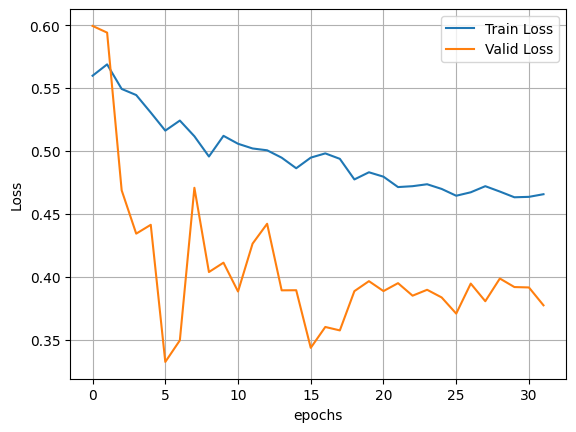

In [32]:
plt.plot( range(len(history["Train Loss"])), history["Train Loss"], label="Train Loss")
plt.plot( range(len(history["Valid Loss"])), history["Valid Loss"], label="Valid Loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

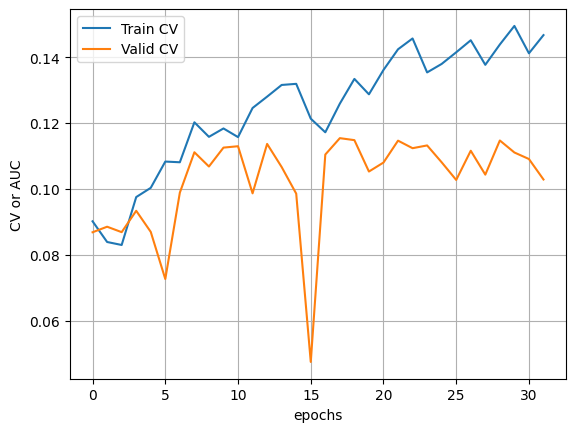

In [33]:
plt.plot( range(len(history["Train CV"])), history["Train CV"], label="Train CV")
plt.plot( range(len(history["Valid CV"])), history["Valid CV"], label="Valid CV")
plt.xlabel("epochs")
plt.ylabel("CV or AUC")
plt.grid()
plt.legend()
plt.show()

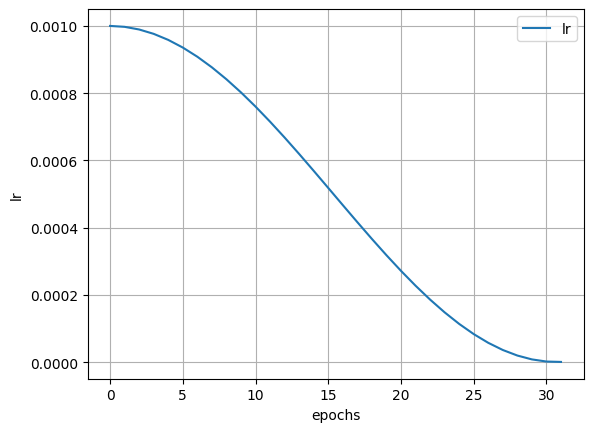

: 

In [34]:
plt.plot( range(len(history["lr"])), history["lr"], label="lr")
plt.xlabel("epochs")
plt.ylabel("lr")
plt.grid()
plt.legend()
plt.show()